# Stock Prediction of Google stocks

In [2]:
import pandas_datareader as pdr

In [3]:
df = pdr.get_data_tiingo('GOOGL',api_key=key)

C:\Users\PhaniHarshith\AppData\Roaming\Python\Python311\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)


In [4]:
df.to_csv('GOOGL.csv')

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [6]:
df = pd.read_csv("GOOGL.csv")

In [7]:
#data starts at 
df.head(1)

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOGL,2019-04-12 00:00:00+00:00,1222.73,1223.05,1213.29,1215.62,1215610,61.1365,61.1525,60.6645,60.781,24312200,0.0,1.0


In [8]:
#data end at
df.tail(1)

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1255,GOOGL,2024-04-09 00:00:00+00:00,156.6,158.56,155.19,156.085,30739691,156.6,158.56,155.19,156.085,30739691,0.0,1.0


In [9]:
df1 = df['close']

In [10]:
df1.shape

(1256,)

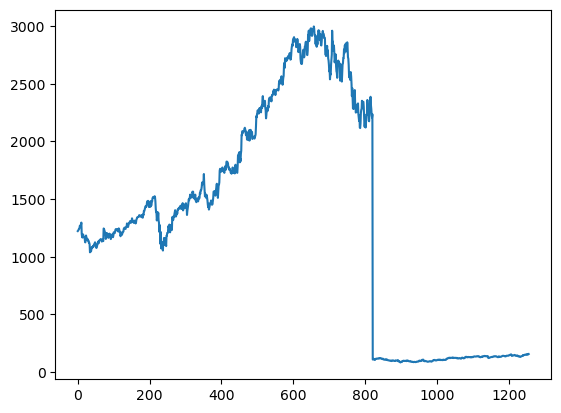

In [11]:
plt.plot(df1)

In [12]:
# As LSTM's are sensitive to the scale of the data we will scale the data.

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [14]:
#train and test split
train_size = int(len(df1) * 0.65)
test_size = len(df1)-train_size
train_data,test_data = df1[0:train_size,:],df1[train_size:len(df1),:1]

In [15]:
train_size,test_size

(816, 440)

In [16]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [17]:
# reshapng into X=t,t+1,t+2,t+3 and Y=t+4
# where t,t+1,t+2,t+3 are the features which will be used to predict 
# the next value of stock and t+4 is the next value of stock
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [18]:
print(X_train.shape), print(y_train.shape)

(715, 100)
(715,)


(None, None)

In [19]:
print(X_test.shape), print(ytest.shape)

(339, 100)
(339,)


(None, None)

In [20]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [21]:
### Creating the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [22]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 6s 215ms/step - loss: 0.1664 - val_loss: 0.0246
Epoch 2/100
12/12 [==============================] - 1s 104ms/step - loss: 0.0182 - val_loss: 0.0322
Epoch 3/100
12/12 [==============================] - 1s 98ms/step - loss: 0.0090 - val_loss: 0.0164
Epoch 4/100
12/12 [==============================] - 1s 102ms/step - loss: 0.0052 - val_loss: 0.0145
Epoch 5/100
12/12 [==============================] - 1s 100ms/step - loss: 0.0027 - val_loss: 0.0077
Epoch 6/100
12/12 [==============================] - 1s 99ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 7/100
12/12 [==============================] - 1s 97ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 8/100
12/12 [==============================] - 1s 99ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/100
12/12 [==============================] - 1s 99ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 10/100
12/12 [==============================] - 1s 98ms/step - loss: 0.0011 - val_loss: 0.

In [26]:
import tensorflow as tf

In [27]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 20ms/step


In [28]:
##Transformback to original form as they are in normalized form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [29]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

2049.7842153829683

In [30]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

166.748444403378

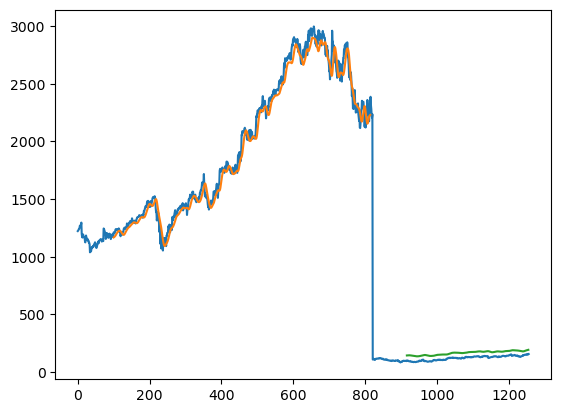

In [31]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Predicting Future Data

In [32]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 99)

In [33]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [34]:
temp_input

[0.01757089800709838,
 0.01836380237116162,
 0.017807739570389995,
 0.01813039329429452,
 0.018377532316859686,
 0.018899270253386148,
 0.018281422696973228,
 0.018185313077086776,
 0.01845647950462355,
 0.017697900004805485,
 0.016853508344374497,
 0.016623531753931914,
 0.01573451776998222,
 0.016324905434999003,
 0.015991954251820935,
 0.01836380237116162,
 0.017697900004805485,
 0.01711437731263772,
 0.01685007585794998,
 0.016867238290072556,
 0.016650991645328038,
 0.016877535749346105,
 0.01797593140519129,
 0.01826769275127517,
 0.018847782957018402,
 0.019561740133317768,
 0.019929016180741006,
 0.019939313640014555,
 0.019544577701195193,
 0.019496522891251956,
 0.019311168624328086,
 0.018789430687801624,
 0.01904686716964034,
 0.018178448104237743,
 0.017951904000219676,
 0.019019407278244214,
 0.019743661913817122,
 0.02020018260827778,
 0.02013153287978746,
 0.020327184605984885,
 0.020272264823192623,
 0.019922151207891967,
 0.020612080979219724,
 0.02160750204232942,
 0

In [37]:
# prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.0183638  0.01780774 0.01813039 0.01837753 0.01889927 0.01828142
 0.01818531 0.01845648 0.0176979  0.01685351 0.01662353 0.01573452
 0.01632491 0.01599195 0.0183638  0.0176979  0.01711438 0.01685008
 0.01686724 0.01665099 0.01687754 0.01797593 0.01826769 0.01884778
 0.01956174 0.01992902 0.01993931 0.01954458 0.01949652 0.01931117
 0.01878943 0.01904687 0.01817845 0.0179519  0.01901941 0.01974366
 0.02020018 0.02013153 0.02032718 0.02027226 0.01992215 0.02061208
 0.0216075  0.02147364 0.02183405 0.02240384 0.02349194 0.02360006
 0.02405486 0.02335121 0.0194519  0.01981574 0.02023451 0.02068073
 0.0208249  0.02131917 0.02144618 0.02250681 0.02200224 0.02118187
 0.02145647 0.02036837 0.01959606 0.01980201 0.02029286 0.02082146
 0.02077684 0.01858348 0.01903314 0.01817502 0.01888897 0.01843588
 0.01713497 0.01690156 0.01646564 0.01748852 0.01784206 0.01861781
 0.0189027  0.01934549 0.02048165 0.01982261 0.02205373 0.02183061
 0.02241757 0.02202627 0.02311436 0.02287409 0.023